# Behandler datasettene for luftkvalitet og værdata:

Sjekker gjennom om det er feil i datasettene før de kombineres:

In [24]:
import pandas as pd

# Les inn datasett
df = pd.read_csv("../data/R_Sammenslaaing_uten_feil.csv")
df_luft = pd.read_csv("../data/R_luftkvalitet.csv")

# Konverter og sørg for at begge har kolonnen "date"
df = df.rename(columns={"Dato": "date"})
df["date"] = pd.to_datetime(df["date"])
df_luft["date"] = pd.to_datetime(df_luft["date"])

# Sjekk resultatet
print(df.columns)
print(df_luft.columns)


Index(['date', 'Temperatur (°C)', 'Lufttrykk (hPa)', 'Nedbør (mm)',
       'Relativ fuktighet (%)', 'Skydekke (oktas)'],
      dtype='object')
Index(['date', 'pm2_5', 'pm10', 'no2', 'o3'], dtype='object')


Sjekker for manglende verdier i datasettene

In [25]:
missing_values = df.isnull().sum();
missing_values_luft = df_luft.isnull().sum();
# Skriv ut antall manglende verdier per kolonne
print("Antall manglende verdier")
print(missing_values);
print(missing_values_luft)

print(f"Antall rader i df (værdata): {len(df)}")
print(f"Antall rader i df_luft (luftkvalitet): {len(df_luft)}")

Antall manglende verdier
date                     0
Temperatur (°C)          0
Lufttrykk (hPa)          0
Nedbør (mm)              0
Relativ fuktighet (%)    0
Skydekke (oktas)         0
dtype: int64
date     0
pm2_5    0
pm10     0
no2      0
o3       0
dtype: int64
Antall rader i df (værdata): 730
Antall rader i df_luft (luftkvalitet): 724


Sjekker om datasettene har manglende datoer/rader siden antall rader er forksjellig:

In [26]:
# Finn datoer som finnes i df, men ikke i df_luft
dato_mangler_i_luft = df[~df["date"].isin(df_luft["date"])]

# Finn datoer som finnes i df_luft, men ikke i df
dato_mangler_i_df = df_luft[~df_luft["date"].isin(df["date"])]

# Print datoer i df men ikke i df_luft
print("Datoer i df men ikke i df_luft:")
for dato in dato_mangler_i_luft["date"]:
    print(dato)

# Print datoer i df_luft men ikke i df
print("\nDatoer i df_luft men ikke i df:")
for dato in dato_mangler_i_df["date"]:
    print(dato)

Datoer i df men ikke i df_luft:
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-10-01 00:00:00
2024-07-23 00:00:00
2024-07-24 00:00:00
2024-09-09 00:00:00

Datoer i df_luft men ikke i df:


Ser at luftkvalitet har noen manglende rader. Bruker linær regresjonsmetode til å lage tilnærmet verdi for de manglende radene:

In [27]:
# Sørg for at df_luft har datetime som indeks
df_luft["date"] = pd.to_datetime(df_luft["date"])
df_luft.set_index("date", inplace=True)

# 1. Resample til daglig – dette lager én rad per dag
df_luft_daily = df_luft.resample("D").mean()

# 2. Interpoler manglende verdier mellom eksisterende datoer
df_luft_fylt = df_luft_daily.interpolate(method="linear")

# (Valgfritt) Vis antall tidligere manglende verdier
print("Antall manglende verdier før interpolering:")
print(df_luft_daily.isna().sum())

print("\nAntall manglende verdier etter interpolering:")
print(df_luft_fylt.isna().sum())

Antall manglende verdier før interpolering:
pm2_5    6
pm10     6
no2      6
o3       6
dtype: int64

Antall manglende verdier etter interpolering:
pm2_5    0
pm10     0
no2      0
o3       0
dtype: int64


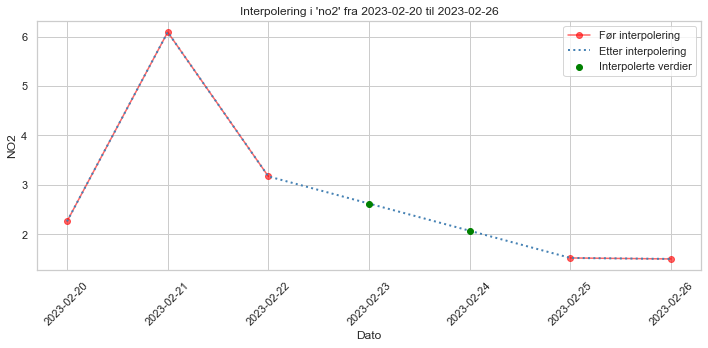

In [28]:
import matplotlib.pyplot as plt

# Velg hvilken variabel du vil vise
kolonne = "no2"

# Angi intervall der du vet interpolering har skjedd
start_dato = "2023-02-20"
slutt_dato = "2023-02-26"

# Filtrer datasettet til det valgte datointervallet
original = df_luft_daily.loc[start_dato:slutt_dato]
interpolert = df_luft_fylt.loc[start_dato:slutt_dato]

# Finn hvilke datoer som ble interpolert
mangler = df_luft_daily[kolonne].isna()
interpolerte_datoer = df_luft_daily[mangler].loc[start_dato:slutt_dato].index

# Lag plott
plt.figure(figsize=(10, 5))

# Før interpolering
plt.plot(original.index, original[kolonne], label="Før interpolering", color='red', marker='o', alpha=0.6)

# Etter interpolering
plt.plot(interpolert.index, interpolert[kolonne], label="Etter interpolering",linestyle=':', color='steelblue', linewidth=2)

# Marker interpolerte verdier
plt.scatter(interpolerte_datoer, df_luft_fylt.loc[interpolerte_datoer, kolonne],
            color='green', label="Interpolerte verdier", zorder=5)

plt.title(f"Interpolering i '{kolonne}' fra {start_dato} til {slutt_dato}")
plt.xlabel("Dato")
plt.ylabel(kolonne.upper())
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

For å vise tydlig hvordan interpoleringen er gjort blir det kun plottet et lite intervall. Plottet viser hvordan interpoleringen er blitt gjort for de manglende verdiene. 

Kombinerer datasettene nå som de er behandlet:

In [29]:
df_combined = pd.merge(df, df_luft_fylt, on="date", how="inner")

# Søylediagramm- NO2

Et søylediagram er brukt for å plotte NO₂-data fordi det gir en tydelig visuell fremstilling av konsentrasjonen over tid og gjør det enkelt å identifisere manglende verdier eller uteliggere i datasettet. Det gikk ikke å hente ut historisk data for luftkvalitet fra MET som ble tidligere brukt og dataen ble derfor hentet ut ved openweatherma. Videre plottes data for å se om det mangler eller uteliggere. 

c:\Users\nora0\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nora0\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


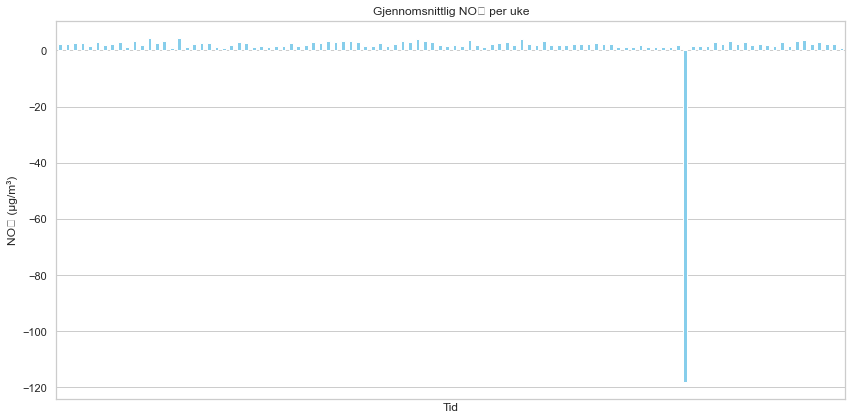

In [35]:
import matplotlib.pyplot as plt


# Henter ut for hver uke
weekly_no2 = df_luft["no2"].resample("W").mean()

# Ble rotete å ha navn på x-aksen for hver uke, en søyle representerer en uke
plt.figure(figsize=(12, 6))
weekly_no2.plot(kind="bar", color="skyblue")

plt.title("Gjennomsnittlig NO₂ per uke")
plt.ylabel("NO₂ (µg/m³)")
plt.xlabel("Tid")

plt.xticks([], [])  # Skjuler X-akse etiketter
plt.tight_layout()
plt.show()



Ser at den er en verdi som er ugyldig, sjekker dette ved å printe ut de 10 laveste verdiene i datasettet:

In [36]:
print(weekly_no2.sort_values().head(10))

date
2024-08-11   -117.918571
2025-01-05      0.920000
2023-06-04      1.034286
2023-04-16      1.058571
2023-03-05      1.068571
2023-05-28      1.110000
2024-06-09      1.131429
2024-02-04      1.204286
2024-06-16      1.265714
2023-07-16      1.284286
Name: no2, dtype: float64


Ser uteligger på 08.11.2024 da dette ikke er en gyldig verdi for NO2. Metoden for å behandle uteliggere er Interquartile Range (IQR).

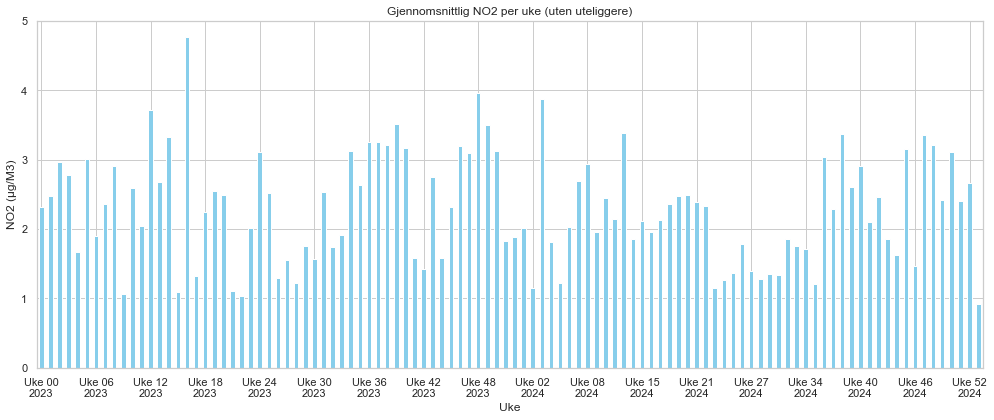

In [47]:
# IQR-outlier (Fra jupyter-boken)
Q1 = weekly_no2.quantile(0.25) # Nedre 25%
Q3 = weekly_no2.quantile(0.75) # Øvre 75%
IQR = Q3 - Q1
# Grense for normale verdier
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

# Filtrer ut uteliggere
weekly_no2_clean = weekly_no2[(weekly_no2 >= lower_bound) & (weekly_no2 <= upper_bound)]

# Formatér indeks til uke og år
#weekly_no2_clean.index = weekly_no2_clean.index.to_period("W").strftime("Uke %W\n%Y")
tick_labels = weekly_no2_clean.index.to_period("W").strftime("Uke %W\n%Y")



# PLOT:
figur_no2, akse_no2 = plt.subplots(figsize=(14, 6))

# Tegner søylediagramm ved bruk av "bar"
weekly_no2_clean.plot(kind="bar", color="skyblue", ax=akse_no2)

akse_no2.set_title("Gjennomsnittlig NO2 per uke (uten uteliggere)")
akse_no2.set_ylabel("NO2 (µg/M3)")
akse_no2.set_xlabel("Uke")

# Plottet viser hver uke, men teksten på x-aksen viser hver 6 uke for å gjøre det renere
akse_no2.set_xticks(range(0, len(weekly_no2_clean), 6))
akse_no2.set_xticklabels(tick_labels[::6], rotation=0, ha='center')

#akse_no2.set_xticks(range(0, len(weekly_no2_clean), 6))
#akse_no2.set_xticklabels(weekly_no2_clean.index[::6], rotation=0, ha='center')

figur_no2.tight_layout()

### Visualisering av maglende data


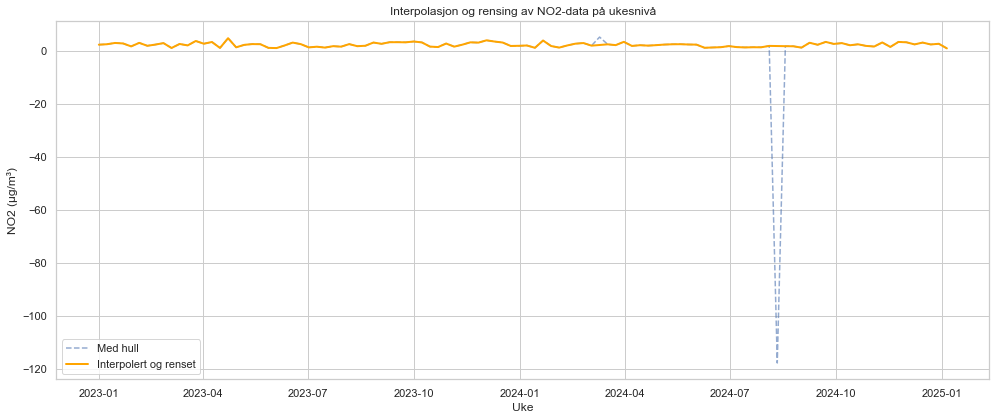

In [48]:

# 5. Plott
plt.figure(figsize=(14, 6))
plt.plot(weekly_no2, label="Med hull", linestyle="--", alpha=0.6)
plt.plot(weekly_no2_clean, label="Interpolert og renset", color="orange", linewidth=2)

plt.title("Interpolasjon og rensing av NO2-data på ukesnivå")
plt.xlabel("Uke")
plt.ylabel("NO2 (µg/m³)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap

Bruker heatmap til å se korrelasjon mellom alle verdiene. Dette kan brukes videre til å se hva som er interessant å lage visuallisering av.

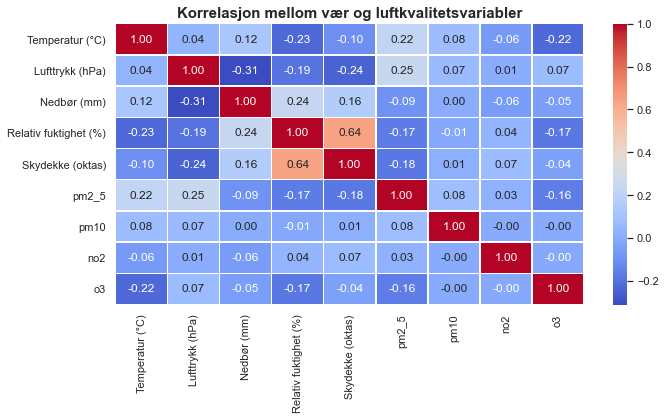

In [49]:
import seaborn as sns
# Filtrer kun numeriske kolonner manuelt
numeric_df = df_combined.select_dtypes(include=["number"])
corr_matrix = numeric_df.corr()

# Lag heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Korrelasjon mellom vær og luftkvalitetsvariabler", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

Ser fra heatmap at skydekke og relativ luftfuktighet har sterk korrelasjon. Ser også at nedbør og lufttrykk har sterk korrelasjon. Begge disse stemmer sterkt overens, noe som er i tråd med meteorologisk forskning, der det ofte observeres at værforhold som høy luftfuktighet og økt skydekke opptrer samtidig, samt at nedbør ofte henger sammen med lavt lufttrykk.

# Linjediagramemed Seaborn
Linjediagram er brukt for å visualisere skydekke og relativ luftfuktighet fordi denne diagramtypen egner seg godt til å vise hvordan verdier utvikler seg over tid. I tillegg gjør linjediagram det enklere å sammenligne to tidsserier (skydekke og luftfuktighet) ved å bruke to y-akser, og å se samvariasjon mellom dem.


In [58]:
# Setter dato tilbake til kolonne
df_combined = df_combined.reset_index()
print(df_combined.columns)


ValueError: cannot insert level_0, already exists

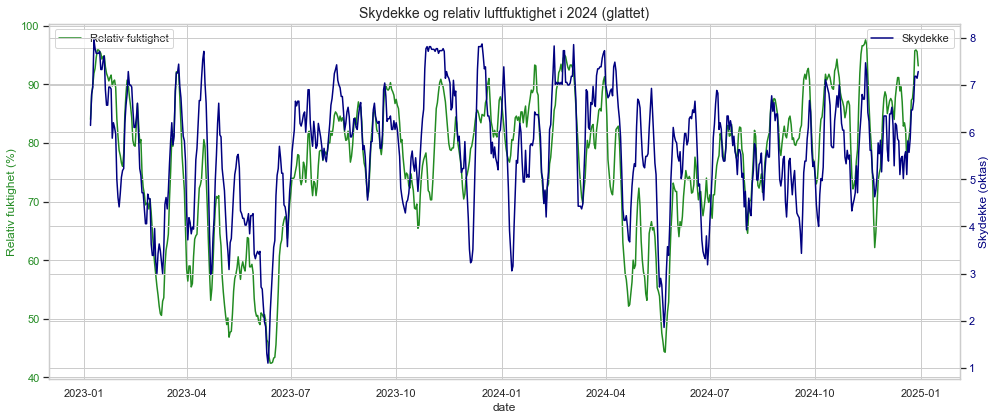

In [60]:
# Glidende gjennomsnitt
df_combined["Skydekke_smooth"] = df_combined["Skydekke (oktas)"].rolling(window=7).mean()
df_combined["Fuktighet_smooth"] = df_combined["Relativ fuktighet (%)"].rolling(window=7).mean()

# Seaborn-stil
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 6))

# Relativ fuktighet (venstre)
line1 = sns.lineplot(data=df_combined, x="date", y="Fuktighet_smooth", ax=ax1, color="forestgreen")
ax1.set_ylabel("Relativ fuktighet (%)", color="forestgreen")
ax1.tick_params(axis='y', labelcolor="forestgreen")

# Skydekke (høyre)
ax2 = ax1.twinx()
line2 = sns.lineplot(data=df_combined, x="date", y="Skydekke_smooth", ax=ax2, color="navy")
ax2.set_ylabel("Skydekke (oktas)", color="navy")
ax2.tick_params(axis='y', labelcolor="navy")

# Legg til separate legends
ax1.legend(["Relativ fuktighet"], loc="upper left")
ax2.legend(["Skydekke"], loc="upper right")

# Tittel og layout
plt.title("Skydekke og relativ luftfuktighet i 2024 (glattet)", fontsize=14)
fig.tight_layout()
plt.show()



# Predikativ analyse

MSE: 3.14
R^2: 0.40
RMSE: 1.77


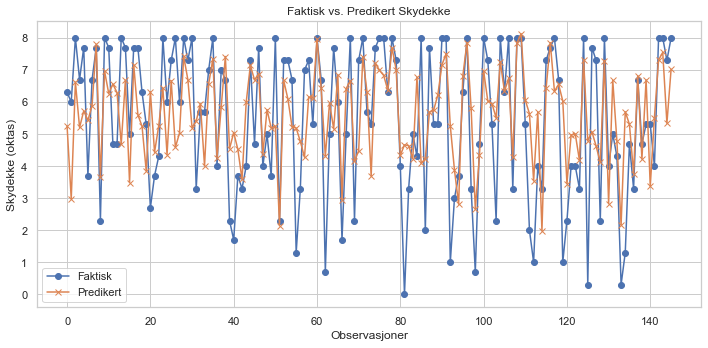

In [73]:

from sklearn.preprocessing import StandardScaler
import joblib

# 2. Last inn og klargjør data
df_vær = pd.read_csv("../data/R_Sammenslaaing_uten_feil.csv")
df_luft = pd.read_csv("../data/R_luftkvalitet.csv")

df_vær["Dato"] = pd.to_datetime(df_vær["Dato"])
df_luft["date"] = pd.to_datetime(df_luft["date"])
df_luft.set_index("date", inplace=True)

# Slå sammen datasettene (reset_index sikrer samme struktur)
df_samlet = pd.concat([df_vær.reset_index(drop=True), df_luft.reset_index(drop=True)], axis=1)

# 3. Velg funksjoner og målvariabel
X = df_samlet[["Temperatur (°C)", "Lufttrykk (hPa)", "Relativ fuktighet (%)"]]
y = df_samlet["Skydekke (oktas)"]

# 4. Splitte data i trening og test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Standardisering av data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Tren lineær regresjonsmodell
modell = LinearRegression()
modell.fit(X_train_scaled, y_train)

# 7. Gjør prediksjoner
y_pred = modell.predict(X_test_scaled)

# 8. Evaluer modellen
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MSE: {mse:.2f}")
print(f"R^2: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")

# 9. Visualisering: Faktisk vs. Predikert skydekke
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Faktisk", marker='o')
plt.plot(y_pred, label="Predikert", marker='x')
plt.title("Faktisk vs. Predikert Skydekke")
plt.xlabel("Observasjoner")
plt.ylabel("Skydekke (oktas)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Lagre modell og scaler for fremtidig bruk

joblib.dump(modell, "modell_skydekke.pkl");
joblib.dump(scaler, "scaler_skydekke.pkl");

Mean square error regner ut gjennomsnittet av kvadrerte feil mellom de faktiske og predikerte veridene. 
RMSE er da roten av MSE og sier at feilmarginen på de predikerte veridene er i snitt 1.77. Dette betyr at modellen bommer i sitt +/- 1.77 oktas.

R*2 sier hvor mye av variasjonen skydekke-modellen som forklares av modellen. 0.4  vil si at 40% kan forklares av temperatur, lufttrykk og luftfuktighet. Dette tilsvarer ikke mye, men modellen er noe fungerende.

### Morsom bruk av regresjonsmodellen
Velger en random simulering for å simulere en dag og sier til bruker om sjangsen for regn ut i fra skydekke og fuktighet og da om man bør ta med paraply:
 

In [67]:
import random
ny_observasjon = X_test.sample(1, random_state=random.randint(1, 10000))
ny_observasjon_scaled = scaler.transform(ny_observasjon)
pred_skydekke = modell.predict(ny_observasjon_scaled)[0]


def bør_ta_med_paraply(skydekke, fuktighet):
    if skydekke > 6 and fuktighet > 80:
        return "Ta med paraply!"
    elif skydekke > 4:
        return "Kanskje grått, men ikke sikkert du trenger paraply."
    else:
        return "Ingen grunn til paraply, nyt sola!"

# Bruk verdiene fra observasjonen over
fuktighet = ny_observasjon["Relativ fuktighet (%)"].values[0]
print(bør_ta_med_paraply(pred_skydekke, fuktighet))

Ta med paraply!
